# Sales Data Preprocessing - Step 3

This notebook follows the previous outlier detection and removal steps. It focuses on:

1. Loading the cleaned monthly sales data files
2. Processing sales data with proper feature engineering
3. Creating lag features (only 14+ days as required for forecasting horizons)
4. Handling missing values appropriately based on business logic
5. Calculating seasonality components using time series decomposition
6. Saving the processed dataset for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
from datetime import datetime, timedelta
import warnings

# For seasonality decomposition
from statsmodels.tsa.seasonal import STL, seasonal_decompose

# Enable autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# Add parent directory to path
sys.path.append('..')

# Suppress warnings
warnings.filterwarnings('ignore')

# Set Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')

# Import our modules
from src.sales.preprocess import (
    load_monthly_data,
    create_hierarchical_categories,
    create_date_features,
    create_promotion_features,
    create_price_features,
    create_lag_features,
    create_sales_performance_metrics,
    handle_missing_values,
    process_sales_data
)

## 1. Configuration and Setup

Define paths and settings for data processing.

In [2]:
# Set data paths
data_dir = '../data/'
output_dir = '../data/processed/'
output_file = os.path.join(output_dir, 'sales_processed.csv')

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Set parameters
MONTHS = list(range(1, 13))  # Process all months (1-12)
YEAR = 2023
USE_CLEAN_FILES = True  # Use files with outliers removed

## 2. Load Cleaned Sales Data

Load the monthly sales data files. If clean files exist (with outliers removed), those will be loaded.
Otherwise, it will fall back to the original files.

In [3]:
# Load sales data from monthly files
print(f"Loading data for {len(MONTHS)} months of {YEAR}...")
print(f"Attempting to use clean files first: {USE_CLEAN_FILES}")

df_sales = load_monthly_data(output_dir, months=MONTHS, year=YEAR, clean_files=USE_CLEAN_FILES)

if df_sales.empty:
    print("No data loaded. Please check file paths and try again.")
else:
    print(f"Loaded sales data with {len(df_sales):,} rows and {len(df_sales.columns)} columns")
    print(f"Date range: {df_sales['calday'].min()} to {df_sales['calday'].max()}")
    
    # Display sample of the data
    print("\nSample of loaded data:")
    display(df_sales.head())

2025-05-14 00:31:11,519 - src.sales.preprocess - INFO - Found 12 cleaned data files
2025-05-14 00:31:11,520 - src.sales.preprocess - INFO - Found 12 data files to load
2025-05-14 00:31:11,520 - src.sales.preprocess - INFO - Loading 202301_clean.csv...


Loading data for 12 months of 2023...
Attempting to use clean files first: True


2025-05-14 00:31:21,935 - src.sales.preprocess - INFO - Loaded 2366473 rows from 202301_clean.csv
2025-05-14 00:31:21,936 - src.sales.preprocess - INFO - Loading 202302_clean.csv...
2025-05-14 00:31:37,113 - src.sales.preprocess - INFO - Loaded 2103964 rows from 202302_clean.csv
2025-05-14 00:31:37,115 - src.sales.preprocess - INFO - Loading 202303_clean.csv...
2025-05-14 00:31:53,890 - src.sales.preprocess - INFO - Loaded 2389280 rows from 202303_clean.csv
2025-05-14 00:31:53,892 - src.sales.preprocess - INFO - Loading 202304_clean.csv...
2025-05-14 00:32:11,482 - src.sales.preprocess - INFO - Loaded 2468642 rows from 202304_clean.csv
2025-05-14 00:32:11,484 - src.sales.preprocess - INFO - Loading 202305_clean.csv...
2025-05-14 00:32:31,752 - src.sales.preprocess - INFO - Loaded 2800536 rows from 202305_clean.csv
2025-05-14 00:32:31,753 - src.sales.preprocess - INFO - Loading 202306_clean.csv...
2025-05-14 00:32:51,424 - src.sales.preprocess - INFO - Loaded 2763482 rows from 202306_cl

Loaded sales data with 39,299,982 rows and 35 columns
Date range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00

Sample of loaded data:


,matrix_type,promo_from,promo_to,type_bonus_id,qnt,qnt_loss,discount,action_mediana_price,reg_mediana_price,bu_exists,...,geolocal_type,format_merch,calday,week_iso,regular_price,action_price,group_students,index_material,index_store,source_month
0,P,NaN,NaN,NaN,NaN,0.0,NaN,NaN,130.0455,0,...,season,S,2023-01-11,2,130.0455,NaN,cannibalization,481,41,01
1,P,20230103.0,20230123.0,0,2.0,0.0,0.00,219.990000,379.9905,0,...,traffic,H,2023-01-11,2,379.9905,219.99,weather,2090,10,01
2,A,NaN,NaN,NaN,11.0,0.0,NaN,102.694545,105.0605,0,...,traffic,H,2023-01-11,2,105.0605,NaN,cannibalization,1479,14,01
3,P,20221130.0,20231130.0,0,NaN,0.0,0.00,NaN,103.0655,0,...,season,S,2023-01-11,2,103.0655,59.99,weather,341,45,01
4,A,20221228.0,20230131.0,ZB05,NaN,0.0,0.15,NaN,99.0755,1,...,mixed,H,2023-01-11,2,99.0755,88.65,weather,1933,2,01


## 3. Check for Missing Values

Let's examine the missing values in our dataset before processing.

Columns with missing values (before processing):


,Missing Values,Missing Percent
type_bonus_id,25577444,65.082585
qnt,23550540,59.925066
action_mediana_price,23550540,59.925066
action_price,22127129,56.303153
promo_to,20424858,51.971673
promo_from,20424858,51.971673
discount,20424858,51.971673
reg_mediana_price,15731579,40.029481
last_action_mediana_price,6685534,17.011545
last_reg_mediana_price,1606531,4.087867


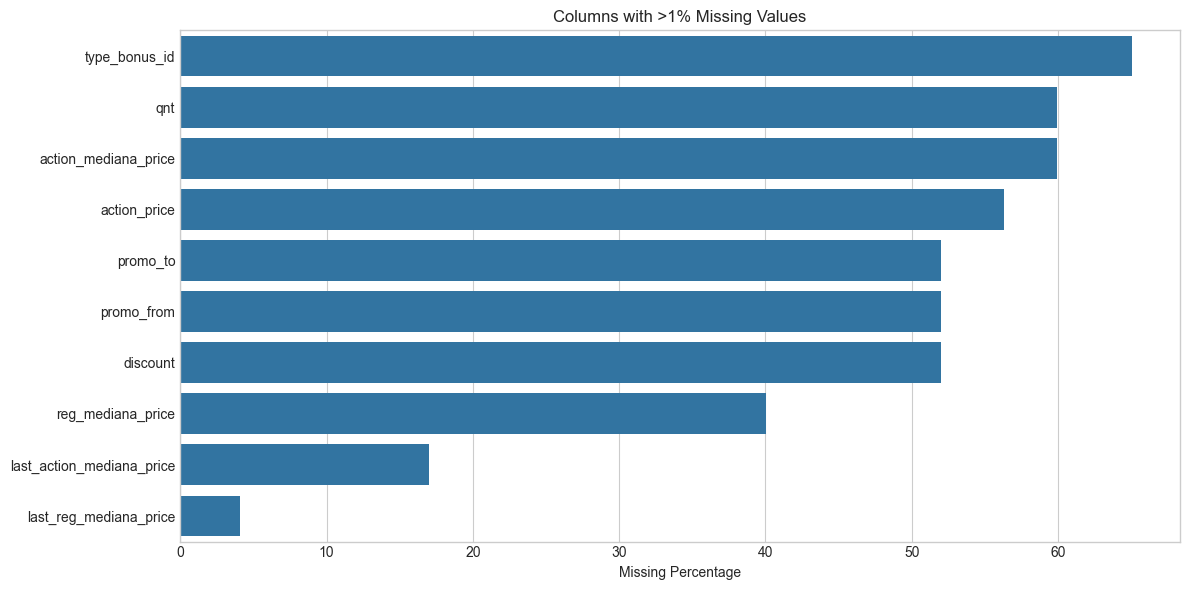

In [4]:
# Check for missing values
missing_values = df_sales.isnull().sum()
missing_percent = missing_values / len(df_sales) * 100

# Create a DataFrame for better visualization
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percent': missing_percent
})

# Sort by missing percentage
missing_info = missing_info.sort_values('Missing Percent', ascending=False)

# Display columns with missing values
print("Columns with missing values (before processing):")
display(missing_info[missing_info['Missing Values'] > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_cols = missing_info[missing_info['Missing Percent'] > 1].index.tolist()
if missing_cols:
    sns.barplot(x=missing_info.loc[missing_cols, 'Missing Percent'], y=missing_cols)
    plt.title('Columns with >1% Missing Values')
    plt.xlabel('Missing Percentage')
    plt.tight_layout()
    plt.show()
else:
    print("No columns with more than 1% missing values")

## 4. Create Hierarchical Category Features

Create hierarchical category features from subcat_id.

Creating hierarchical category features...


2025-05-14 00:40:21,425 - src.sales.preprocess - INFO - Created hierarchical category features
2025-05-14 00:40:28,717 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-14 00:40:28,743 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


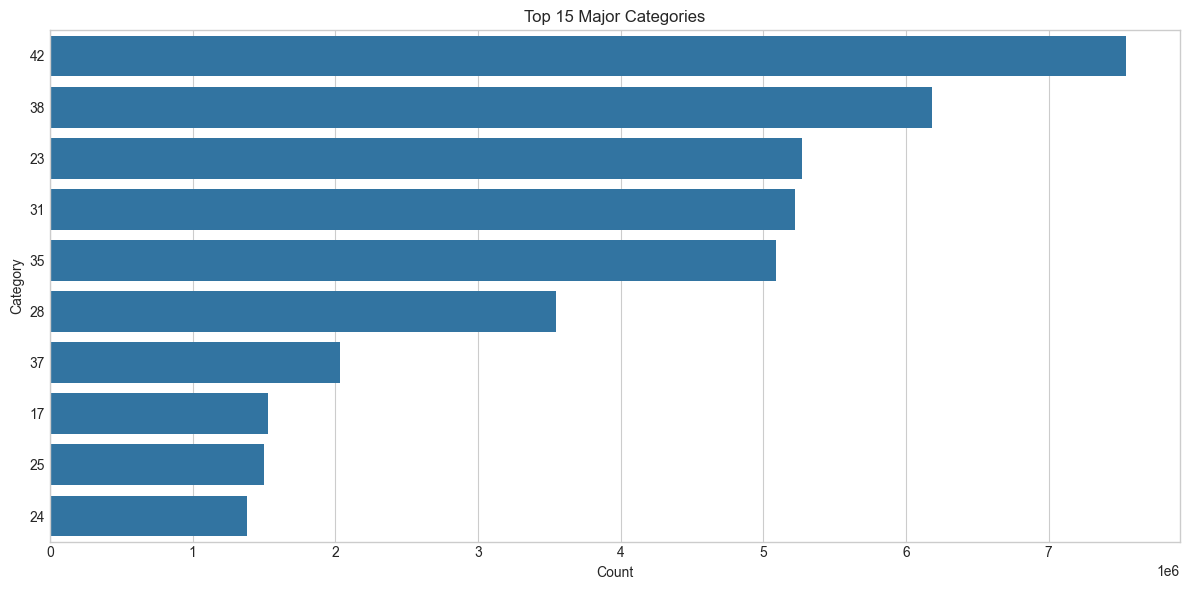

Removed subcat_id column after creating hierarchical categories


In [5]:
# Create hierarchical category features
print("Creating hierarchical category features...")
df_sales = create_hierarchical_categories(df_sales)

# Display the distribution of major categories
if 'category_major' in df_sales.columns:
    plt.figure(figsize=(12, 6))
    category_counts = df_sales['category_major'].value_counts().sort_values(ascending=False).head(15)
    sns.barplot(x=category_counts.values, y=category_counts.index.astype(str))
    plt.title('Top 15 Major Categories')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()
    
# Remove subcat_id after creating hierarchical categories
if 'subcat_id' in df_sales.columns:
    df_sales = df_sales.drop(columns=['subcat_id'])
    print("Removed subcat_id column after creating hierarchical categories")

## 5. Create Date Features

Add date-related features to enrich the dataset.

Creating date features...
calday type before conversion: datetime64[ns]
calday sample values before conversion: ['2023-01-11T00:00:00.000000000' '2023-01-11T00:00:00.000000000'
 '2023-01-11T00:00:00.000000000']


2025-05-14 00:42:08,624 - src.sales.preprocess - INFO - Created date features


Dropped promo date columns (using relative days features instead)

Date features created successfully. Sample results:
      calday  day_of_week  month  year
0 2023-01-11            2      1  2023
1 2023-01-11            2      1  2023
2 2023-01-11            2      1  2023
3 2023-01-11            2      1  2023
4 2023-01-11            2      1  2023


2025-05-14 00:42:53,704 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-14 00:42:53,747 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


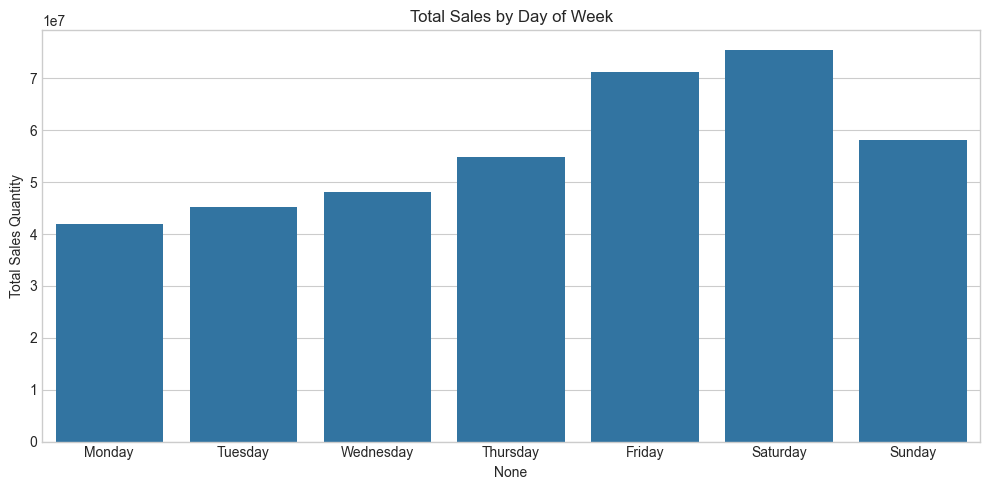

In [6]:
# Create date features
print("Creating date features...")

# Show the data type and format of calday before conversion
if 'calday' in df_sales.columns:
    print(f"calday type before conversion: {df_sales['calday'].dtype}")
    print(f"calday sample values before conversion: {df_sales['calday'].head(3).values}")

df_sales = create_date_features(df_sales)

# Drop promo date columns as they're no longer needed after preprocessing
if 'promo_from' in df_sales.columns and 'promo_to' in df_sales.columns:
    df_sales = df_sales.drop(columns=['promo_from', 'promo_to'])
    print("Dropped promo date columns (using relative days features instead)")

# Verify the date conversion and feature creation
if all(col in df_sales.columns for col in ['calday', 'day_of_week', 'month', 'year']):
    print("\nDate features created successfully. Sample results:")
    print(df_sales[['calday', 'day_of_week', 'month', 'year']].head())

# Display sales by day of week
if all(col in df_sales.columns for col in ['day_of_week', 'qnt']):
    plt.figure(figsize=(10, 5))
    day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    daily_sales = df_sales.groupby('day_of_week')['qnt'].sum()
    daily_sales.index = [day_names.get(i, i) for i in daily_sales.index]
    sns.barplot(x=daily_sales.index, y=daily_sales.values)
    plt.title('Total Sales by Day of Week')
    plt.ylabel('Total Sales Quantity')
    plt.tight_layout()
    plt.show()

## 6. Create Promotion Features

Add features related to promotions and discounts.

Creating promotion features...


2025-05-14 00:44:08,784 - src.sales.preprocess - INFO - Identified 16579141 promotion records (42.19%)


Promotion records: 16,579,141 (42.19% of data)


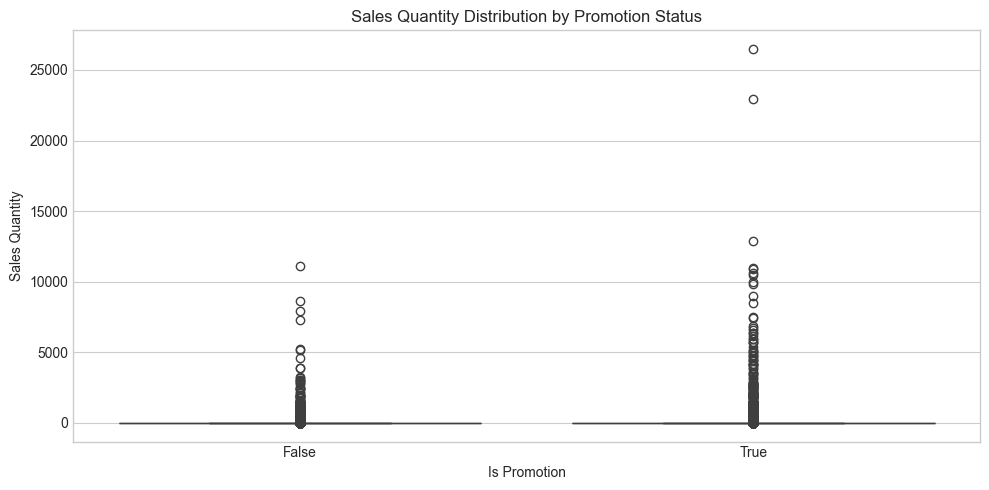

In [7]:
# Create promotion features
print("Creating promotion features...")
df_sales = create_promotion_features(df_sales)

# Display promotion information
if 'is_promo' in df_sales.columns:
    promo_count = df_sales['is_promo'].sum()
    promo_percent = promo_count / len(df_sales) * 100
    print(f"Promotion records: {promo_count:,} ({promo_percent:.2f}% of data)")
    
    # Compare sales with and without promotion
    if 'qnt' in df_sales.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x='is_promo', y='qnt', data=df_sales.sample(min(100000, len(df_sales))))
        plt.title('Sales Quantity Distribution by Promotion Status')
        plt.xlabel('Is Promotion')
        plt.ylabel('Sales Quantity')
        plt.tight_layout()
        plt.show()

## 7. Create Price Features

Add features related to prices and discounts.

Creating price features...


2025-05-14 00:45:26,851 - src.sales.preprocess - INFO - Created price comparison features


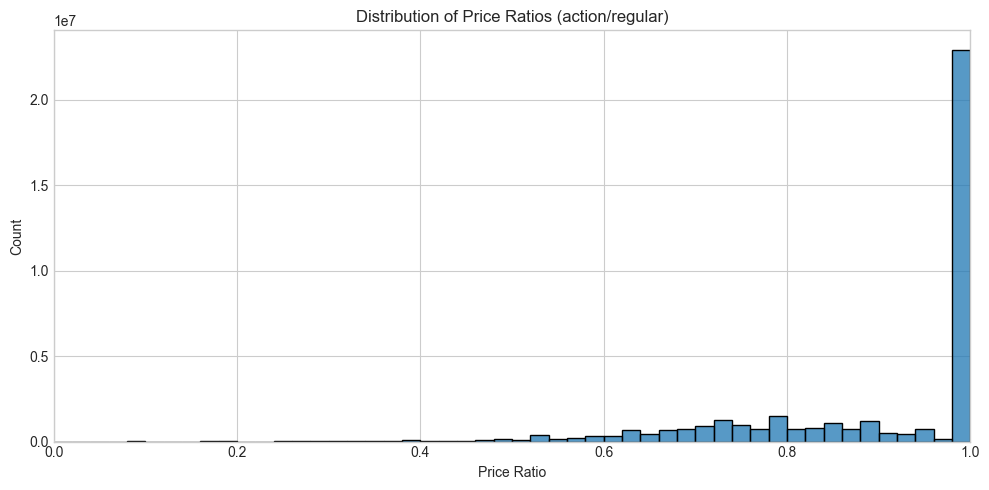

In [8]:
# Create price features
print("Creating price features...")
df_sales = create_price_features(df_sales)

# Display price ratio distribution
if 'price_ratio' in df_sales.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_sales['price_ratio'].dropna(), bins=50)
    plt.title('Distribution of Price Ratios (action/regular)')
    plt.xlabel('Price Ratio')
    plt.ylabel('Count')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

## 8. Handle Missing Values

Apply business logic to handle missing values in the dataset.

In [9]:
# Handle missing values
print("Handling missing values...")
df_sales = handle_missing_values(df_sales)

# Check remaining missing values
missing_after = df_sales.isnull().sum()
missing_percent_after = missing_after / len(df_sales) * 100

# Create a DataFrame for comparison
missing_comparison = pd.DataFrame({
    'Before - Missing': missing_values,
    'Before - Percent': missing_percent,
    'After - Missing': missing_after,
    'After - Percent': missing_percent_after
})

# Display only the rows where there were missing values before
print("Missing values before and after handling:")
display(missing_comparison[(missing_values > 0) | (missing_after > 0)].sort_values('Before - Percent', ascending=False))

2025-05-14 00:46:36,385 - src.sales.preprocess - INFO - Handling missing values


Handling missing values...


2025-05-14 00:49:12,201 - src.sales.preprocess - INFO - Columns with significant missing values (>1%):
2025-05-14 00:49:12,257 - src.sales.preprocess - INFO -   type_bonus_id: 65.08% missing (25577444 values)
2025-05-14 00:49:12,260 - src.sales.preprocess - INFO -   qnt: 59.93% missing (23550540 values)
2025-05-14 00:49:12,263 - src.sales.preprocess - INFO -   action_mediana_price: 59.93% missing (23550540 values)
2025-05-14 00:49:12,265 - src.sales.preprocess - INFO -   action_price: 56.30% missing (22127129 values)
2025-05-14 00:49:12,267 - src.sales.preprocess - INFO -   discount: 51.97% missing (20424858 values)
2025-05-14 00:49:12,271 - src.sales.preprocess - INFO -   reg_mediana_price: 40.03% missing (15731579 values)
2025-05-14 00:49:12,274 - src.sales.preprocess - INFO -   last_action_mediana_price: 17.01% missing (6685534 values)
2025-05-14 00:49:12,278 - src.sales.preprocess - INFO -   last_reg_mediana_price: 4.09% missing (1606531 values)
2025-05-14 00:49:12,507 - src.sales.

Missing values before and after handling:


,Before - Missing,Before - Percent,After - Missing,After - Percent
type_bonus_id,25577444.0,65.082585,0.0,0.0
action_mediana_price,23550540.0,59.925066,0.0,0.0
qnt,23550540.0,59.925066,0.0,0.0
action_price,22127129.0,56.303153,0.0,0.0
discount,20424858.0,51.971673,0.0,0.0
promo_from,20424858.0,51.971673,NaN,NaN
promo_to,20424858.0,51.971673,NaN,NaN
reg_mediana_price,15731579.0,40.029481,0.0,0.0
last_action_mediana_price,6685534.0,17.011545,0.0,0.0
last_reg_mediana_price,1606531.0,4.087867,0.0,0.0


## 9. Create Lag Features (14+ Days Only)

Add lag features with lags of 14 days or more to respect the forecast horizon.

In [10]:
# Create lag features (only 14+ days)
print("Creating lag features (14+ days only)...")

lag_days = [14, 21, 28]
print(f"Using lag days: {lag_days}")

df_sales = create_lag_features(
    df=df_sales,
    target_col='qnt',
    group_cols=['index_store', 'index_material'],
    lag_days=lag_days,
    date_col='calday'
)

# Check for the created lag columns
lag_cols = [col for col in df_sales.columns if '_lag_' in col]
print(f"Created {len(lag_cols)} lag feature columns:")
print(lag_cols)

2025-05-14 00:54:48,753 - src.sales.preprocess - INFO - Creating lag features (14+ days) for 'qnt'


Creating lag features (14+ days only)...
Using lag days: [14, 21, 28]


2025-05-14 00:56:25,138 - src.sales.preprocess - INFO - Aggregating data by store, product, and date...
2025-05-14 00:57:06,903 - src.sales.preprocess - INFO - Created qnt_lag_14d
2025-05-14 00:57:09,200 - src.sales.preprocess - INFO - Created qnt_lag_21d
2025-05-14 00:57:11,520 - src.sales.preprocess - INFO - Created qnt_lag_28d
2025-05-14 00:57:19,680 - src.sales.preprocess - INFO - Created qnt_lag_avg as average of individual lags
2025-05-14 00:57:20,707 - src.sales.preprocess - INFO - Merging lag features back to main dataframe...
2025-05-14 01:04:53,601 - src.sales.preprocess - INFO - Lag features creation complete


Created 4 lag feature columns:
['qnt_lag_14d', 'qnt_lag_21d', 'qnt_lag_28d', 'qnt_lag_avg']


## 10. Create Sales Performance Metrics

Calculate basic sales statistics including maximum, minimum, mean and median sales quantities.

Creating sales performance metrics...

Sales performance metrics statistics:
            qnt_max       qnt_min      qnt_mean    qnt_median
count  3.929998e+07  3.929998e+07  3.929998e+07  3.929998e+07
mean   1.399963e+02  6.127527e-02  1.004674e+01  3.009330e+00
std    1.561101e+03  3.232989e+00  9.615345e+01  3.541093e+01
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    7.000000e+00  0.000000e+00  3.956386e-01  0.000000e+00
50%    1.300000e+01  0.000000e+00  1.035533e+00  0.000000e+00
75%    3.000000e+01  0.000000e+00  2.653333e+00  1.000000e+00
max    1.244410e+05  6.850000e+02  4.814065e+03  1.954000e+03


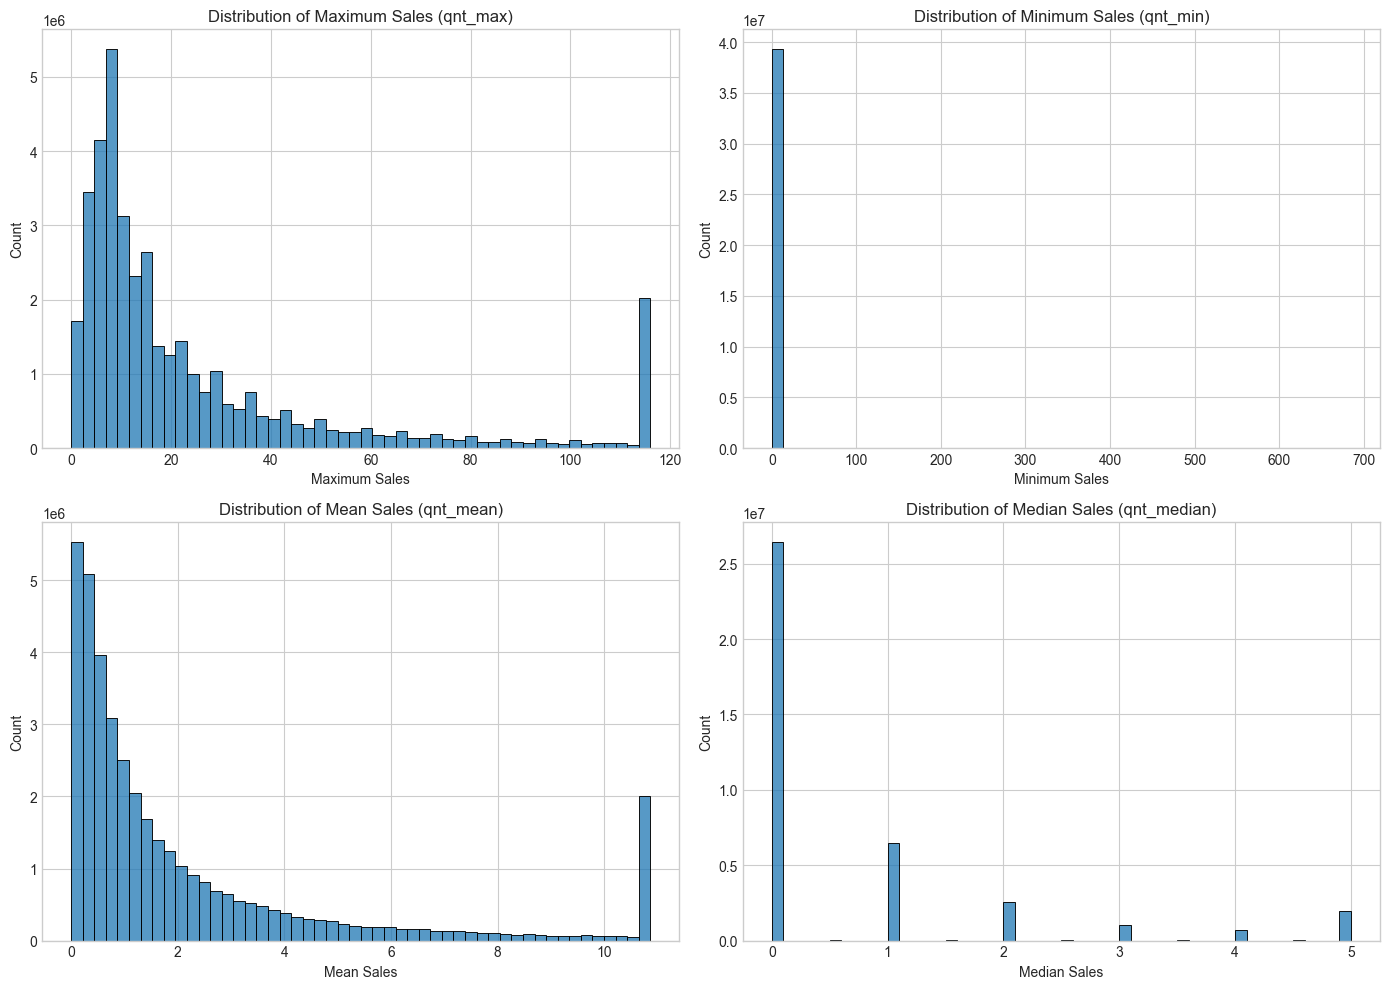

In [11]:
# Create sales performance metrics
print("Creating sales performance metrics...")

# Group by product and store to calculate statistics
group_cols = ['index_store', 'index_material']
sales_stats = df_sales.groupby(group_cols)['qnt'].agg([
    ('qnt_max', 'max'),
    ('qnt_min', 'min'),
    ('qnt_mean', 'mean'),
    ('qnt_median', 'median')
])

# Reset index to join with original dataframe
sales_stats = sales_stats.reset_index()

# Merge statistics back to the original dataframe
df_sales = df_sales.merge(sales_stats, on=group_cols, how='left')

# Display statistics for these new features
print("\nSales performance metrics statistics:")
print(df_sales[['qnt_max', 'qnt_min', 'qnt_mean', 'qnt_median']].describe())

# Plot distribution of metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Use clipping to better visualize distributions without extreme outliers
sns.histplot(df_sales['qnt_max'].clip(upper=df_sales['qnt_max'].quantile(0.95)), bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Maximum Sales (qnt_max)')
axes[0, 0].set_xlabel('Maximum Sales')

sns.histplot(df_sales['qnt_min'], bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Minimum Sales (qnt_min)')
axes[0, 1].set_xlabel('Minimum Sales')

sns.histplot(df_sales['qnt_mean'].clip(upper=df_sales['qnt_mean'].quantile(0.95)), bins=50, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Mean Sales (qnt_mean)')
axes[1, 0].set_xlabel('Mean Sales')

sns.histplot(df_sales['qnt_median'].clip(upper=df_sales['qnt_median'].quantile(0.95)), bins=50, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Median Sales (qnt_median)')
axes[1, 1].set_xlabel('Median Sales')

plt.tight_layout()
plt.show()

## 10.5 Remove Unnecessary Columns

Remove columns that are no longer needed after feature engineering.

In [12]:
# Remove unnecessary columns
columns_to_drop = ['city_id', 'group_students']

# Check which columns exist before dropping
existing_cols = [col for col in columns_to_drop if col in df_sales.columns]

if existing_cols:
    df_sales = df_sales.drop(columns=existing_cols)
    print(f"Removed unnecessary columns: {existing_cols}")
else:
    print("No columns to remove - they may have been removed in earlier steps")

print(f"Current dataframe shape: {df_sales.shape}")

Removed unnecessary columns: ['city_id', 'group_students']
Current dataframe shape: (39299982, 60)


## 11. Seasonality Analysis with Time Series Decomposition

Extract seasonal patterns from sales data using time series decomposition techniques.

Calculating seasonality components using time series decomposition...

Analyzing global seasonality patterns...


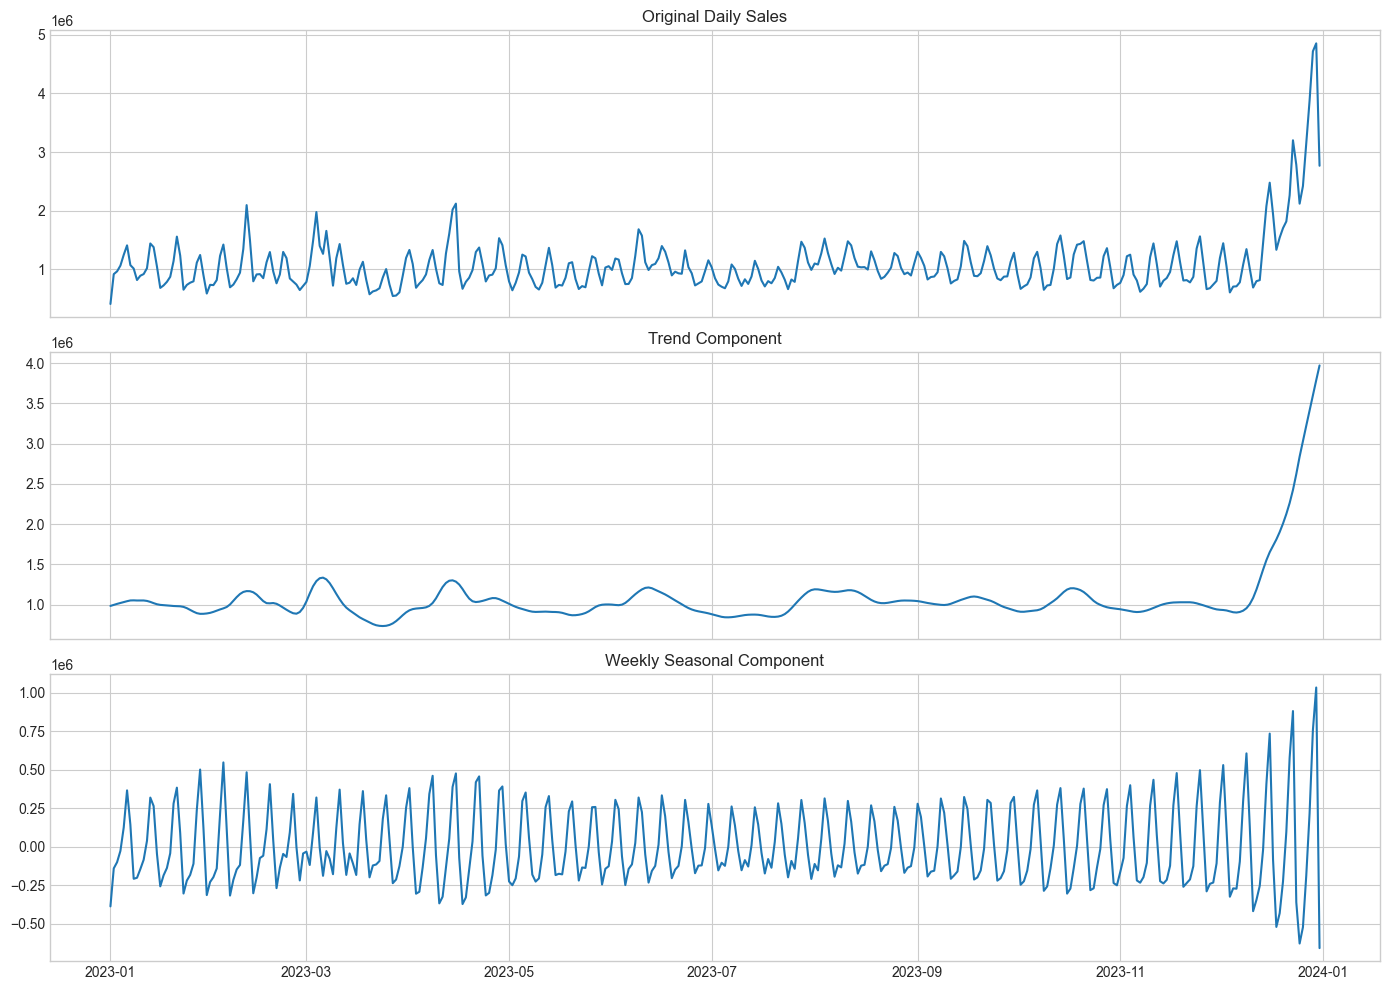

Added day-of-week seasonal effect

Day of week seasonal effects:
Monday: -252011.29
Tuesday: -195993.81
Wednesday: -147581.61
Thursday: -22660.71
Friday: 286036.89
Saturday: 353724.85
Sunday: -17184.80

Analyzing monthly seasonality patterns...


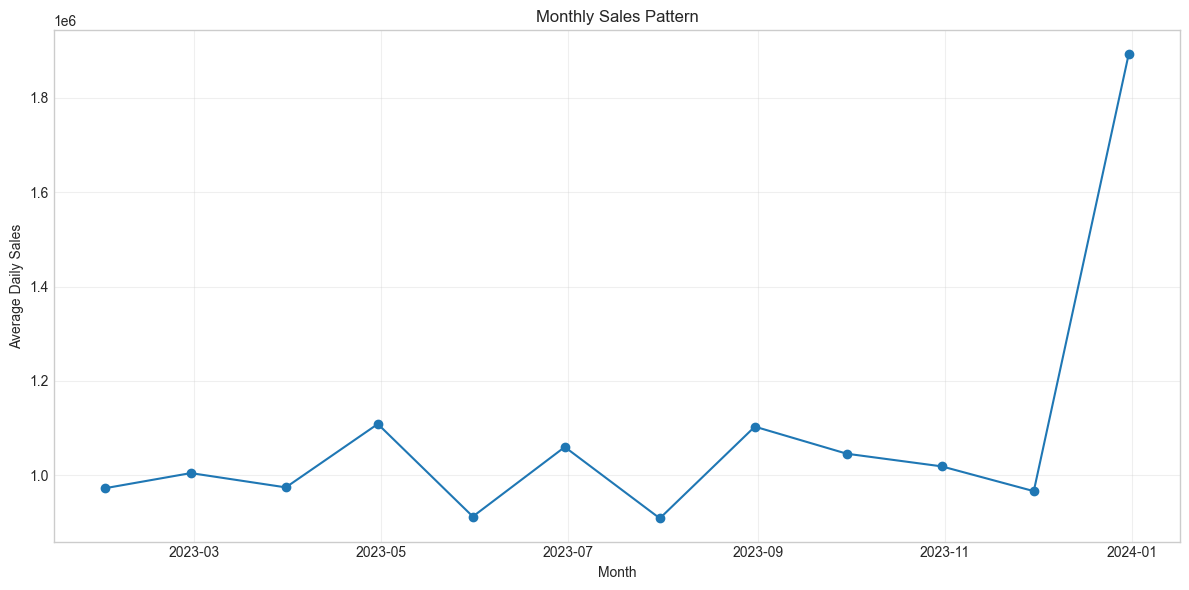

Added monthly seasonal effect

Monthly seasonal effects (relative to average):
Jan: 0.90
Feb: 0.93
Mar: 0.90
Apr: 1.03
May: 0.84
Jun: 0.98
Jul: 0.84
Aug: 1.02
Sep: 0.97
Oct: 0.94
Nov: 0.89
Dec: 1.75

Analyzing product-level seasonality for top products...

Analyzing seasonality for product 910...


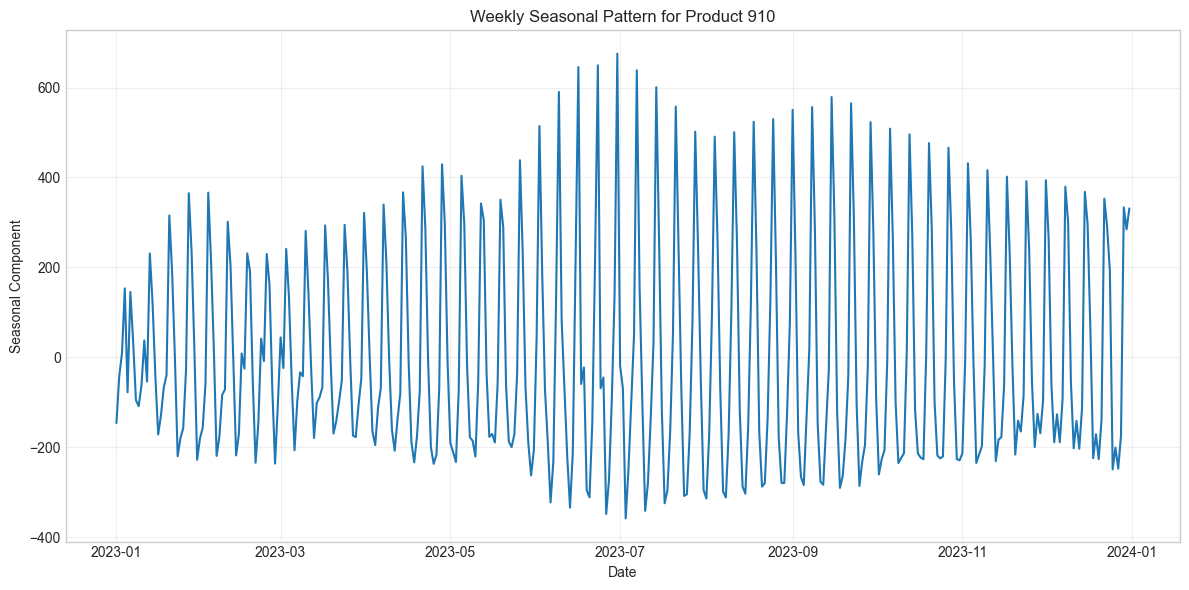


Analyzing seasonality for product 911...


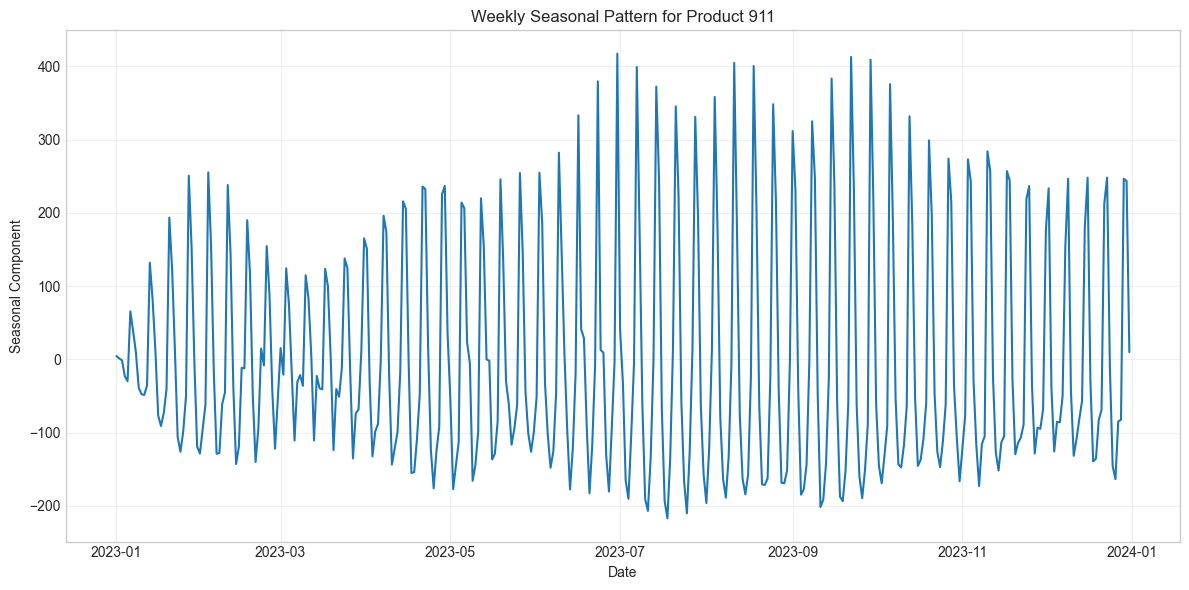


Analyzing seasonality for product 1399...


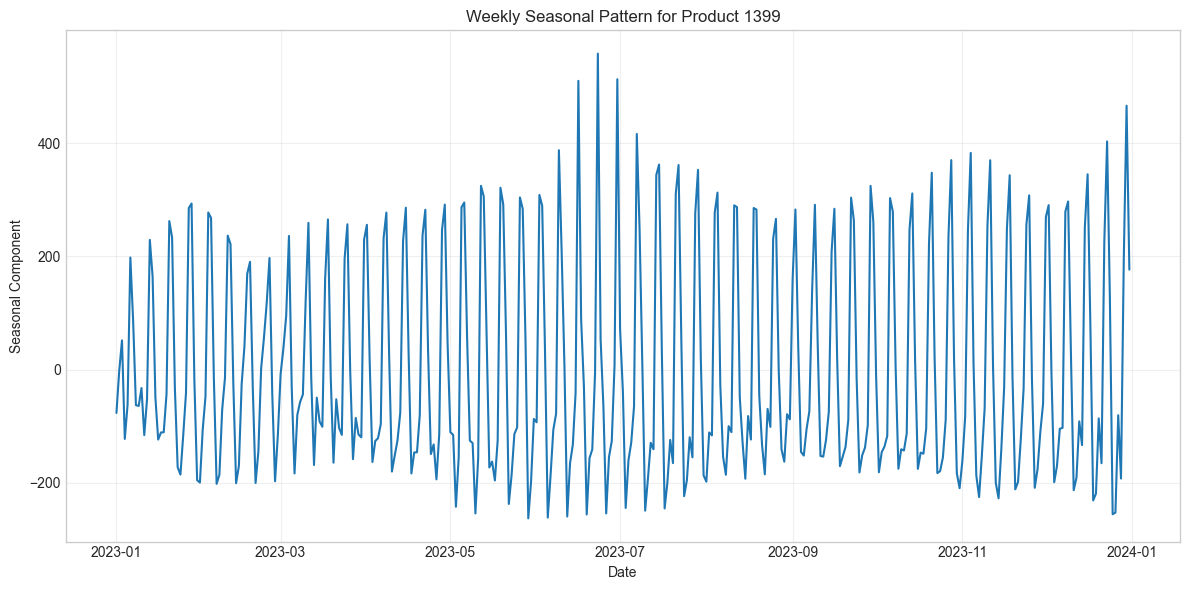


Analyzing seasonality for product 652...


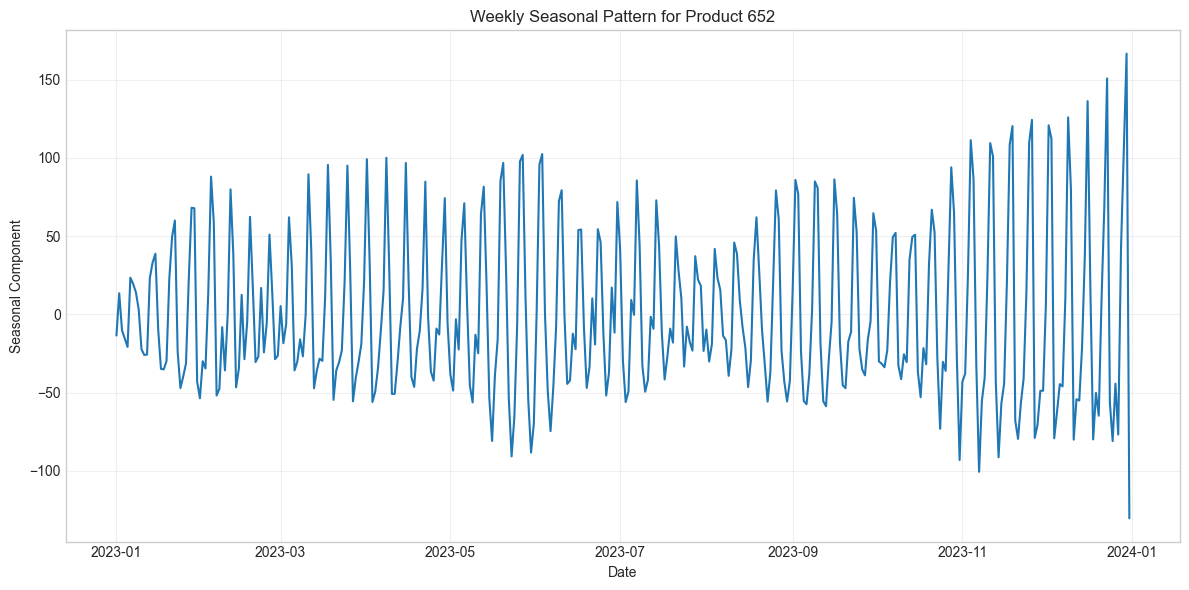


Analyzing seasonality for product 413...


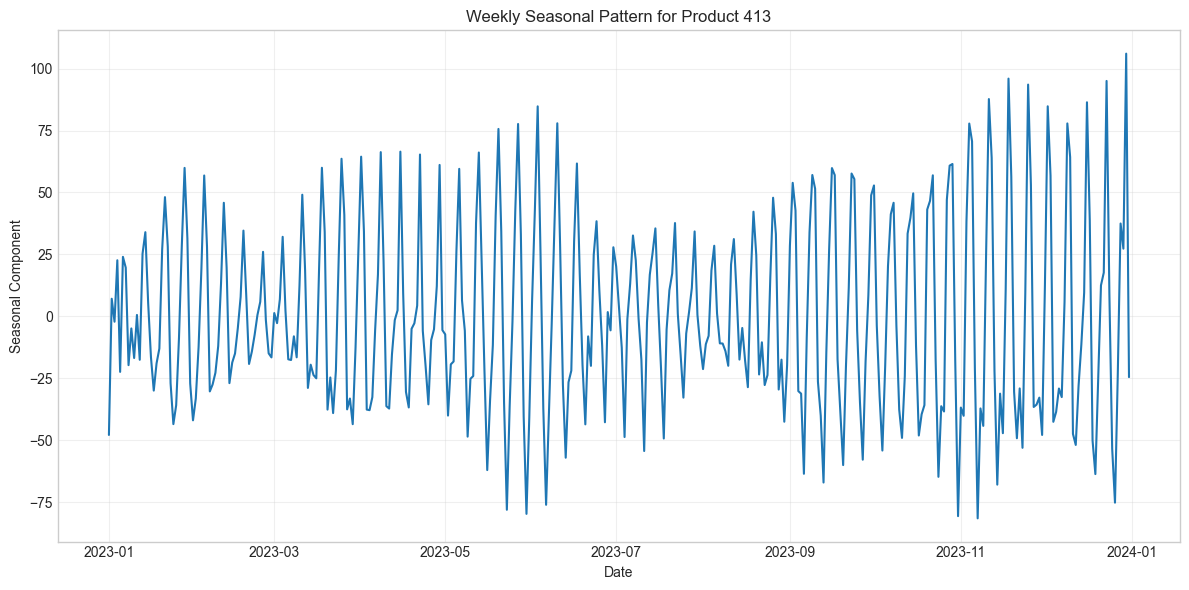


Calculating product-specific seasonality features...
Analyzing 101746 product-store combinations (sampling for efficiency)...
Processed 50/1000 groups
Processed 100/1000 groups
Processed 150/1000 groups
Processed 200/1000 groups
Processed 250/1000 groups
Processed 300/1000 groups
Processed 350/1000 groups
Processed 400/1000 groups
Processed 450/1000 groups
Processed 500/1000 groups
Processed 550/1000 groups
Processed 600/1000 groups
Processed 650/1000 groups
Processed 700/1000 groups
Processed 750/1000 groups
Processed 800/1000 groups
Processed 850/1000 groups
Processed 900/1000 groups
Processed 950/1000 groups
Processed 1000/1000 groups

Seasonality features added to dataframe:
- seasonal_dow: Day-of-week seasonal effect
- seasonal_month: Monthly seasonal effect
- product_seasonal_strength: Correlation of product sales with overall seasonal pattern
- seasonal_group: Categorization of seasonal strength (Low/Medium/High)


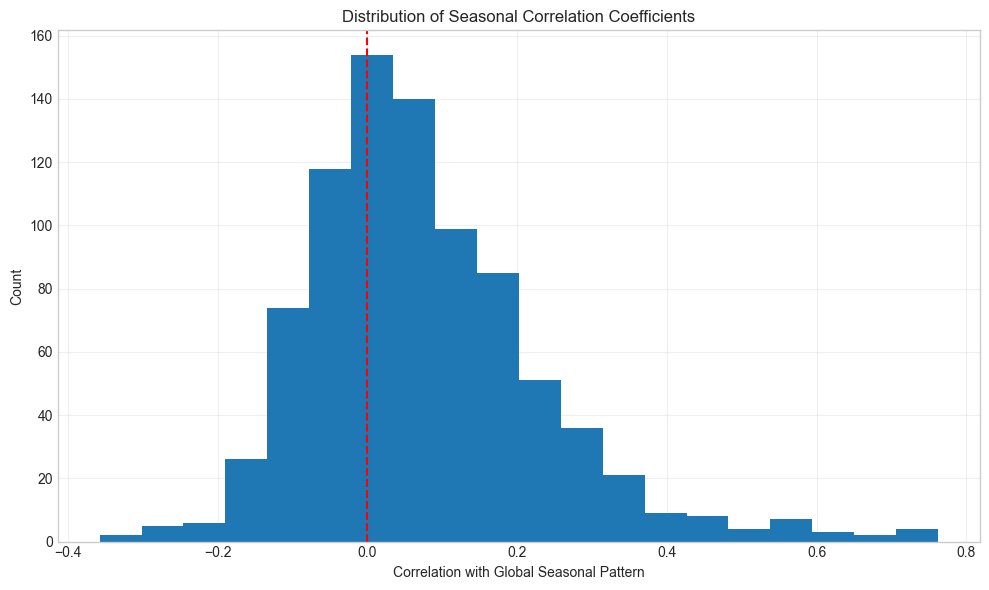

In [13]:
print("Calculating seasonality components using time series decomposition...")

# Ensure calday is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df_sales['calday']):
    df_sales['calday'] = pd.to_datetime(df_sales['calday'])

# Function to decompose time series and extract seasonality
def decompose_time_series(series, period=7):
    """Decompose a time series into trend, seasonal, and residual components."""
    try:
        # Check if we have enough data points
        if len(series) >= 2 * period:
            decomposition = STL(series, period=period).fit()
            return decomposition.trend, decomposition.seasonal, decomposition.resid
        else:
            return None, None, None
    except Exception as e:
        print(f"Error in decomposition: {e}")
        return None, None, None

# 1. Global seasonality analysis (across all products)
print("\nAnalyzing global seasonality patterns...")

# Aggregate daily sales across all products and stores
daily_sales = df_sales.groupby('calday')['qnt'].sum().sort_index()

# Perform weekly seasonality decomposition
trend_w, seasonal_w, resid_w = decompose_time_series(daily_sales, period=7)

if seasonal_w is not None:
    # Plot decomposition results
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    axes[0].plot(daily_sales.index, daily_sales.values)
    axes[0].set_title('Original Daily Sales')
    
    axes[1].plot(daily_sales.index, trend_w)
    axes[1].set_title('Trend Component')
    
    axes[2].plot(daily_sales.index, seasonal_w)
    axes[2].set_title('Weekly Seasonal Component')
    
    plt.tight_layout()
    plt.show()
    
    # Create day-of-week seasonality features
    dow_effect = {}
    for day in range(7):
        # Get seasonal components for this day of week
        day_pattern = seasonal_w[daily_sales.index.dayofweek == day]
        if not day_pattern.empty:
            dow_effect[day] = day_pattern.mean()
    
    # Add seasonal effect to dataframe
    df_sales['seasonal_dow'] = df_sales['day_of_week'].map(dow_effect)
    print("Added day-of-week seasonal effect")
    
    # Show the day of week seasonal effects
    print("\nDay of week seasonal effects:")
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for day, effect in dow_effect.items():
        print(f"{day_names[day]}: {effect:.2f}")

# 2. Monthly seasonality analysis
print("\nAnalyzing monthly seasonality patterns...")

# Resample to monthly data
monthly_sales = daily_sales.resample('M').mean()

if len(monthly_sales) >= 4:  # Need at least a few months of data
    # Plot monthly pattern
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales.index, monthly_sales.values, 'o-')
    plt.title('Monthly Sales Pattern')
    plt.xlabel('Month')
    plt.ylabel('Average Daily Sales')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create monthly seasonality feature
    month_effect = {}
    for month in range(1, 13):
        month_data = monthly_sales[monthly_sales.index.month == month]
        if not month_data.empty:
            month_effect[month] = month_data.mean() / monthly_sales.mean()
    
    # Add monthly seasonal effect to dataframe
    df_sales['seasonal_month'] = df_sales['month'].map(month_effect)
    print("Added monthly seasonal effect")
    
    # Show the monthly seasonal effects
    print("\nMonthly seasonal effects (relative to average):")
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for month, effect in month_effect.items():
        print(f"{month_names[month-1]}: {effect:.2f}")

# 3. Product-level seasonality for top products
print("\nAnalyzing product-level seasonality for top products...")

# Find top products by number of sales records
top_products = df_sales['index_material'].value_counts().head(5).index.tolist()

for product in top_products:
    # Get daily sales for this product
    product_sales = df_sales[df_sales['index_material'] == product]
    daily_product_sales = product_sales.groupby('calday')['qnt'].sum()
    
    if len(daily_product_sales) >= 30:  # Need enough data points
        print(f"\nAnalyzing seasonality for product {product}...")
        trend_p, seasonal_p, _ = decompose_time_series(daily_product_sales, period=7)
        
        if seasonal_p is not None:
            # Plot this product's seasonality
            plt.figure(figsize=(12, 6))
            plt.plot(daily_product_sales.index, seasonal_p)
            plt.title(f'Weekly Seasonal Pattern for Product {product}')
            plt.xlabel('Date')
            plt.ylabel('Seasonal Component')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

# Add column indicating if product's sales follow the overall seasonal pattern
# This requires analyzing correlation between product's seasonality and overall seasonality
print("\nCalculating product-specific seasonality features...")

# Calculate normalized seasonal patterns by product-store combination
product_store_groups = df_sales.groupby(['index_material', 'index_store'])
num_groups = len(product_store_groups)
print(f"Analyzing {num_groups} product-store combinations (sampling for efficiency)...")

# For efficiency, process only a sample of the groups (can take a long time otherwise)
sample_size = min(1000, num_groups)
sampled_groups = np.random.choice(range(num_groups), sample_size, replace=False)

group_seasonal_corrs = []
counter = 0

# Store seasonal correlation by product
product_seasonality = {}

# Progress through sampled groups
for i, ((product, store), group_df) in enumerate(product_store_groups):
    if i in sampled_groups:
        counter += 1
        if counter % 50 == 0:
            print(f"Processed {counter}/{sample_size} groups")
        
        # Get daily sales for this product-store combination
        daily_group_sales = group_df.groupby('calday')['qnt'].sum()
        
        if len(daily_group_sales) >= 30:  # Need enough data points
            # Align with global sales dates
            common_dates = daily_group_sales.index.intersection(daily_sales.index)
            if len(common_dates) >= 30:
                # Calculate correlation with overall seasonal pattern
                group_seasonal = daily_group_sales[common_dates]
                global_seasonal = daily_sales[common_dates]
                
                if not (group_seasonal.std() == 0 or global_seasonal.std() == 0):
                    corr = group_seasonal.corr(global_seasonal)
                    group_seasonal_corrs.append((product, store, corr))
                    
                    # Store correlation by product
                    if product not in product_seasonality:
                        product_seasonality[product] = []
                    product_seasonality[product].append(corr)

# Calculate average seasonal correlation by product
product_avg_corr = {p: np.mean(corrs) for p, corrs in product_seasonality.items()}

# Add product seasonality strength feature to the dataframe
df_sales['product_seasonal_strength'] = df_sales['index_material'].map(product_avg_corr)

# Fill missing values
df_sales['product_seasonal_strength'] = df_sales['product_seasonal_strength'].fillna(0)

# Create seasonality groups
df_sales['seasonal_group'] = pd.cut(
    df_sales['product_seasonal_strength'], 
    bins=[-1, 0.3, 0.6, 1], 
    labels=['Low', 'Medium', 'High']
)

print("\nSeasonality features added to dataframe:")
print("- seasonal_dow: Day-of-week seasonal effect")
print("- seasonal_month: Monthly seasonal effect")
print("- product_seasonal_strength: Correlation of product sales with overall seasonal pattern")
print("- seasonal_group: Categorization of seasonal strength (Low/Medium/High)")

# Show distribution of seasonal correlations
plt.figure(figsize=(10, 6))
plt.hist([corr for _, _, corr in group_seasonal_corrs], bins=20)
plt.title('Distribution of Seasonal Correlation Coefficients')
plt.xlabel('Correlation with Global Seasonal Pattern')
plt.ylabel('Count')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Final Data Overview

Review the final processed dataset.

In [14]:
# Display summary of the final processed dataset
print(f"Final dataset shape: {df_sales.shape}")

# Column types and counts
column_types = df_sales.dtypes.value_counts()
print("\nColumn types:")
print(column_types)

# Group columns by type
column_categories = {
    'Original': [col for col in df_sales.columns if col in df_sales.columns and not ('_' in col and col not in ['qnt_loss', 'type_for_customer', 'week_iso'])],
    'Categorical': [col for col in df_sales.select_dtypes(include=['object', 'category']).columns if col not in ['matrix_type', 'type_bonus_id', 'country_id', 'unit', 'geolocal_type', 'format_merch']],
    'Hierarchical': [col for col in df_sales.columns if col.startswith('category_')],
    'Date': [col for col in df_sales.columns if col.startswith(('day_', 'month_', 'is_month_', 'is_weekend'))],
    'Promotion': [col for col in df_sales.columns if col.startswith(('is_promo', 'days_since_promo', 'days_until_promo', 'is_before_promo', 'is_after_promo', 'is_during_promo', 'is_no_promo', 'promo_duration'))],
    'Price': [col for col in df_sales.columns if col.startswith(('price_ratio', 'price_diff', 'price_discount'))],
    'Lag': [col for col in df_sales.columns if '_lag_' in col],
    'Seasonal': [col for col in df_sales.columns if col.startswith(('seasonal_', 'product_seasonal_', 'seasonal_group'))]
}

# Print column counts by category
print("\nColumn counts by category:")
for category, cols in column_categories.items():
    print(f"{category}: {len(cols)} columns")

# Print a few examples from each category
print("\nSample columns from each category:")
for category, cols in column_categories.items():
    print(f"\n{category} columns (showing up to 5):")
    for col in sorted(cols)[:5]:
        print(f"  - {col}")
    if len(cols) > 5:
        print(f"  - ... {len(cols) - 5} more")

# Show sample of the final dataset
print("\nSample of the final processed dataset:")
display(df_sales.head())

Final dataset shape: (39299982, 64)

Column types:
float64           34
object             9
int64              8
int32              7
bool               4
datetime64[ns]     1
category           1
Name: count, dtype: int64

Column counts by category:
Original: 14 columns
Categorical: 4 columns
Hierarchical: 3 columns
Date: 11 columns
Promotion: 1 columns
Price: 3 columns
Lag: 4 columns
Seasonal: 4 columns

Sample columns from each category:

Original columns (showing up to 5):
  - brutto
  - calday
  - discount
  - month
  - netto
  - ... 9 more

Categorical columns (showing up to 5):
  - category_full
  - season
  - seasonal_group
  - source_month

Hierarchical columns (showing up to 5):
  - category_detailed
  - category_full
  - category_major

Date columns (showing up to 5):
  - day_of_month
  - day_of_month_cos
  - day_of_month_sin
  - day_of_week
  - day_of_week_cos
  - ... 6 more

Promotion columns (showing up to 5):
  - is_promo

Price columns (showing up to 5):
  - price_diff

,matrix_type,type_bonus_id,qnt,qnt_loss,discount,action_mediana_price,reg_mediana_price,bu_exists,brand_id,shelf,...,qnt_lag_28d,qnt_lag_avg,qnt_max,qnt_min,qnt_mean,qnt_median,seasonal_dow,seasonal_month,product_seasonal_strength,seasonal_group
0,P,no_bonus,0.0,0.0,0.00,96.890000,130.0455,0,5674,180.0,...,0.0,2.0,16.0,0.0,1.478528,1.0,-147581.610483,0.8999,0.000000,Low
1,P,0,2.0,0.0,0.00,219.990000,379.9905,0,14716,120.0,...,2.0,4.0,29.0,0.0,1.716779,0.0,-147581.610483,0.8999,0.000000,Low
2,A,no_bonus,11.0,0.0,0.00,102.694545,105.0605,0,4391,35.0,...,25.0,23.5,124.0,0.0,14.216331,8.0,-147581.610483,0.8999,0.023403,Low
3,P,0,0.0,0.0,0.00,77.510000,103.0655,0,3957,547.0,...,0.0,0.0,1.0,0.0,0.012500,0.0,-147581.610483,0.8999,0.103816,Low
4,A,ZB05,0.0,0.0,0.15,86.690000,99.0755,1,29854,365.0,...,0.0,7.5,49.0,0.0,4.571429,2.0,-147581.610483,0.8999,0.000000,Low


## 13. Save Processed Dataset

Save the final processed dataset for modeling.

In [15]:
# Save the processed dataset
print(f"Saving processed dataset to {output_file}...")

# Ensure calday is in string format for CSV export
if 'calday' in df_sales.columns and pd.api.types.is_datetime64_any_dtype(df_sales['calday']):
    df_sales['calday_str'] = df_sales['calday'].dt.strftime('%Y-%m-%d')
    df_sales = df_sales.drop(columns=['calday'])
    df_sales = df_sales.rename(columns={'calday_str': 'calday'})

# Save to CSV
df_sales.to_csv(output_file, index=False)
print(f"Dataset saved successfully to {output_file}")
print(f"Final dataset size: {len(df_sales):,} rows, {len(df_sales.columns)} columns")

Saving processed dataset to ../data/processed/sales_processed.csv...
Dataset saved successfully to ../data/processed/sales_processed.csv
Final dataset size: 39,299,982 rows, 64 columns


## 14. Conclusion

We've successfully processed the sales data by:
1. Loading the cleaned files (with outliers removed)
2. Creating hierarchical category features from subcat_id (then removing it)
3. Adding date, promotion, and price features
4. Adding lag features (14, 21, 28 days to respect the forecast horizon)
5. Calculating sales performance metrics (qnt_max, qnt_min, qnt_mean, qnt_median)
6. Handling missing values using business logic
7. Extracting seasonality components using time series decomposition
8. Removing unnecessary columns (city_id, group_students)

The processed data is now ready for model training and analysis.